In [1]:
# HIDDEN
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

### Example: Deflategate ###
On January 18, 2015, the Indianapolis Colts and the New England Patriots played the American Football Conference (AFC) championship game to determine which of those teams would play in the Super Bowl. After the game, there were allegations that the Patriots' footballs had not been inflated as much as the regulations required; they were softer. This could be an advantage, as softer balls might be easier to catch.

For several weeks, the world of American football was consumed by accusations, denials, theories, and suspicions: the press labeled the topic Deflategate, after the Watergate political scandal of the 1970's. The National Football League (NFL) commissioned an independent analysis. In this example, we will perform our own analysis of the data.

Pressure is often measured in pounds per square inch (psi). NFL rules stipulate that game balls must be inflated to have pressures in the range 12.5 psi and 13.5 psi. Each team plays with 12 balls. Teams have the responsibility of maintaining the pressure in their own footballs, but game officials inspect the balls. Before the start of the AFC game, all the Patriots' balls were at about 12.5 psi. Most of the Colts' balls were at about 13.0 psi. However, these pre-game data were not recorded.

During the second quarter, the Colts intercepted a Patriots ball. On the sidelines, they measured the pressure of the ball and determined that it was below the 12.5 psi threshold. Promptly, they informed officials. 

At half-time, all the game balls were collected for inspection. Two officials, Clete Blakeman and Dyrol Prioleau, measured the pressure in each of the balls. Here are the data; pressure is measured in psi. The Patriots ball that had been intercepted by the Colts was not inspected at half-time. Nor were most of the Colts' balls – the officials simply ran out of time and had to relinquish the balls for the start of second half play.

In [2]:
football = Table.read_table('football.csv')
football = football.drop('Team')
football.show()

Ball,Blakeman,Prioleau
Patriots 1,11.5,11.8
Patriots 2,10.85,11.2
Patriots 3,11.15,11.5
Patriots 4,10.7,11
Patriots 5,11.1,11.45
Patriots 6,11.6,11.95
Patriots 7,11.85,12.3
Patriots 8,11.1,11.55
Patriots 9,10.95,11.35
Patriots 10,10.5,10.9


For each of the 15 balls that were inspected, the two officials got different results. It is not uncommon that repeated measurements on the same object yield different results, especially when the measurements are performed by different people. So we will assign to each the ball the average of the two measurements made on that ball.

In [3]:
football = football.with_column(
    'Combined', (football.column(1)+football.column(2))/2
    )
football.show()

Ball,Blakeman,Prioleau,Combined
Patriots 1,11.5,11.8,11.65
Patriots 2,10.85,11.2,11.025
Patriots 3,11.15,11.5,11.325
Patriots 4,10.7,11,10.85
Patriots 5,11.1,11.45,11.275
Patriots 6,11.6,11.95,11.775
Patriots 7,11.85,12.3,12.075
Patriots 8,11.1,11.55,11.325
Patriots 9,10.95,11.35,11.15
Patriots 10,10.5,10.9,10.7


At a glance, it seems apparent that the Patriots' footballs were at a lower pressure than the Colts' balls. Because some deflation is normal during the course of a game, the independent analysts decided to calculate the drop in pressure from the start of the game. Recall that the Patriots' balls had all started out at about 12.5 psi, and the Colts' balls at about 13.0 psi. Therefore the drop in pressure for the Patriots' balls was computed as 12.5 minus the pressure at half-time, and the drop in pressure for the Colts' balls was 13.0 minus the pressure at half-time.

Let's construct two tables, one for the Patriots data and one for Colts. The final column of each table is the drop in pressure from the starting value.

In [4]:
patriots = football.where('Ball', are.containing('Patriots'))
patriots = patriots.with_column('Drop', 12.5-patriots.column('Combined'))
patriots.show()

Ball,Blakeman,Prioleau,Combined,Drop
Patriots 1,11.5,11.8,11.65,0.85
Patriots 2,10.85,11.2,11.025,1.475
Patriots 3,11.15,11.5,11.325,1.175
Patriots 4,10.7,11,10.85,1.65
Patriots 5,11.1,11.45,11.275,1.225
Patriots 6,11.6,11.95,11.775,0.725
Patriots 7,11.85,12.3,12.075,0.425
Patriots 8,11.1,11.55,11.325,1.175
Patriots 9,10.95,11.35,11.15,1.35
Patriots 10,10.5,10.9,10.7,1.8


In [5]:
colts = football.where('Ball', are.containing('Colts'))
colts = colts.with_column('Drop', 13.0-colts.column('Combined'))
colts

Ball,Blakeman,Prioleau,Combined,Drop
Colts 1,12.7,12.35,12.525,0.475
Colts 2,12.75,12.3,12.525,0.475
Colts 3,12.5,12.95,12.725,0.275
Colts 4,12.55,12.15,12.35,0.65


It looks as though the Patriots' drops were larger than the Colts'. A natural statistic is the difference between the two average drops. We'll work with that, but you are free to repeat the analysis with other natural statistics such as the difference between the overall average drop and that of the Patriots.

In [6]:
patriots_mean = patriots.column('Drop').mean()
colts_mean = colts.column('Drop').mean()

observed_statistic = patriots_mean - colts_mean
observed_statistic

0.73352272727272805

This positive difference reflects the fact that the average drop in pressure of the Patriots' balls was greater than that of the Colts.

Could this difference be due to chance, or are the Patriots' drops too large? This question is very much like the question that we asked in an earlier example about the scores in one section of a large class. We'll set up the null and alternative hypotheses just as we did in that example.

**Null hypothesis.** The Patriots' drops are like a random sample of 11 out of all 15 drops. The average came out higher than that of the Colts' drops due to chance variation.

**Alternative hypotheis.** The Patriots' drops are too large to be the result of chance variation alone.

If the null hypothesis were true, then the Patriots' drops would be comparable to 11 drops drawn at random without replacement from all 15 drops. So let's create an array of all 15 drops and draw at random from it.

In [7]:
drops = Table().with_column(
    'Drop', np.append(patriots.column('Drop'), colts.column('Drop'))
)
drops.show()

Drop
0.85
1.475
1.175
1.65
1.225
0.725
0.425
1.175
1.35
1.8


In [8]:
drops.sample(with_replacement=False).show()

Drop
1.225
1.175
1.175
0.475
1.375
0.425
0.85
0.65
1.35
1.65


Notice the use of `sample` without a sample size. That is because the default sample size used by `sample` is the number of rows of the table; if you don't specify a sample size, you get back a sample of the same size as the original table. This is ideal for our purposes, because when you sample without replacement (by specifiying `with_replacement=False`) the same number of times as there are rows, you end up with a random shuffle of all the rows. Run the cell above a few times to see how the output changes.

We can now use the first 11 rows of the shuffled table as a simulation of the Patriots' drops under the null hypothesis. The remaining four rows form the simulation of the corresponding Colts' drops. We can use these two simulated arrays to simulate our test statistic under the null.

In [13]:
shuffled = drops.sample(with_replacement=False)

new_patriots = shuffled.take(np.arange(11))
new_patriots_mean = new_patriots.column(0).mean()

new_colts = shuffled.take(np.arange(11, drops.num_rows))
new_colts_mean = new_colts.column(0).mean()

simulated_stat = new_patriots_mean - new_colts_mean
simulated_stat

-0.70681818181818212

Run the cell above a few times to see how the test statistic varies. Remember that the simulation is under the null hypothesis that the Patriots' drops are like a random sample of al 15 drops.

It's time for a step that is now familiar. We will do repeated simulations of the test statistic under the null hypothesis. At the end of the simulation, the array `simulated_statistics` will contain all of the simulated test statistics.

In [16]:
simulated_statistics = make_array()
repetitions = 10000

for i in np.arange(repetitions):
    shuffled = drops.sample(with_replacement=False)
    new_patriots_mean = shuffled.take(np.arange(11)).column(0).mean()
    new_colts_mean = shuffled.take(np.arange(11, drops.num_rows)).column(0).mean()
    new_statistic = new_patriots_mean - new_colts_mean
    simulated_statistics = np.append(simulated_statistics, new_statistic)

Now for the empirical P-value, which is the chance (computed under the null hypothesis) of getting a test statistic equal to the one that was observed or more in the direction of the alternative. To figure out how to calculate this, it's important to recall the alternative hypothesis:

**Alternative hypotheis.** The Patriots' drops are too large to be the result of chance variation alone.

The "direction of the alternative" is towards large drops for the Patriots, with correspondingly large values for out test statistic "Patriots' mean - Colts' mean". So the P-value is the chance (computed under the null hypothesis) of getting a test statistic equal to our observed value of 0.73352272727272805 or *larger*.

In [17]:
empirical_P = np.count_nonzero(simulated_statistics >= observed_statistic)/repetitions
empirical_P

0.0027

That's a pretty small P-value. To visualize this, here is the empirical distribution of the test statistic under the null hypothesis, with the observed statistic marked on the horizontal axis.

Observed Statistic: 0.733522727273
Empirical P: 0.0027


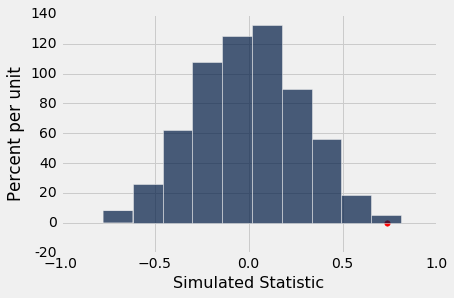

In [20]:
print('Observed Statistic:', observed_statistic)
print('Empirical P:', empirical_P)
results = Table().with_column('Simulated Statistic', simulated_statistics)
results.hist()
plots.scatter(observed_statistic, 0, color='red', s=30);

Notice that the bulk of the distribution is centered around 0. Under the null hypothesis, the Patriots' drops are a random sample of all 15 drops, and therefore so are the Colts'. Therefore the two sets of drops should be about equal on average, and therefore their difference should be around 0.

But the observed value of the test statistic is quite far away from the heart of the distribution. By any reasonable cutoff for what is "small", the empirical P-value is small. So we end up rejecting the null hypothesis of randomness, and conclude that the Patriots drops were too large to reflect chance variation alone.

The independent investiagtive team analyzed the data in several different ways, taking into account the laws of physics. The final report said, 

> "[T]he average pressure drop of the Patriots game balls exceeded the average pressure drop of the Colts balls by 0.45 to 1.02 psi, depending on various possible assumptions regarding the gauges used, and assuming an initial pressure of 12.5 psi for the Patriots balls and 13.0 for the Colts balls."
> 
> -- *Investigative report commissioned by the NFL regarding the AFC Championship game on January 18, 2015*

Our analysis shows an average pressure drop of about 0.73 psi, which is close to the center of the interval "0.45 to 1.02 psi" and therefore consistent with the official analysis.

Remember that our test of hypotheses does not establish the reason *why* the difference is not due to chance. Establishing causality is usually more complex than running a test of hypotheses.

But the all-important question in the football world was about causation: the question was whether the excess drop of pressure in the Patriots' footballs was deliberate. If you are curious about the answer given by the investigators, here is the [full report](https://nfllabor.files.wordpress.com/2015/05/investigative-and-expert-reports-re-footballs-used-during-afc-championsh.pdf).